In [2]:
# Import all necessary libraries

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0, DenseNet121, ResNet50, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Set random seeds 
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

plt.style.use('ggplot')
%matplotlib inline

# Define paths
DATA_DIR = './data/ISIC2018_Task3_Training_Input'
CSV_FILE = './data/ISIC2018_Task3_Training_GroundTruth.csv'
MODEL_SAVE_PATH = './models/skin_lesion_model.keras'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Create directories
os.makedirs('./models', exist_ok=True)
os.makedirs('./plots', exist_ok=True)

In [8]:
# Load and explore the data

In [10]:
def load_isic_data(data_dir, csv_file):
    """Load ISIC dataset and return image paths and labels"""
    df = pd.read_csv(csv_file)
    image_paths = [os.path.join(data_dir, f"{img_id}.jpg") for img_id in df['image']]
    labels_one_hot = df.iloc[:, 1:].values
    labels = labels_one_hot.argmax(axis=1)
    class_names = df.columns[1:].tolist()
    label_names = [class_names[i] for i in labels]
    return image_paths, labels, label_names, class_names

# Load the data
image_paths, labels, label_names, class_names = load_isic_data(DATA_DIR, CSV_FILE)
print(f'Classes: {class_names}')
print(f'Total images: {len(image_paths)}')

Classes: ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
Total images: 10015


In [12]:
# Plot class distribution

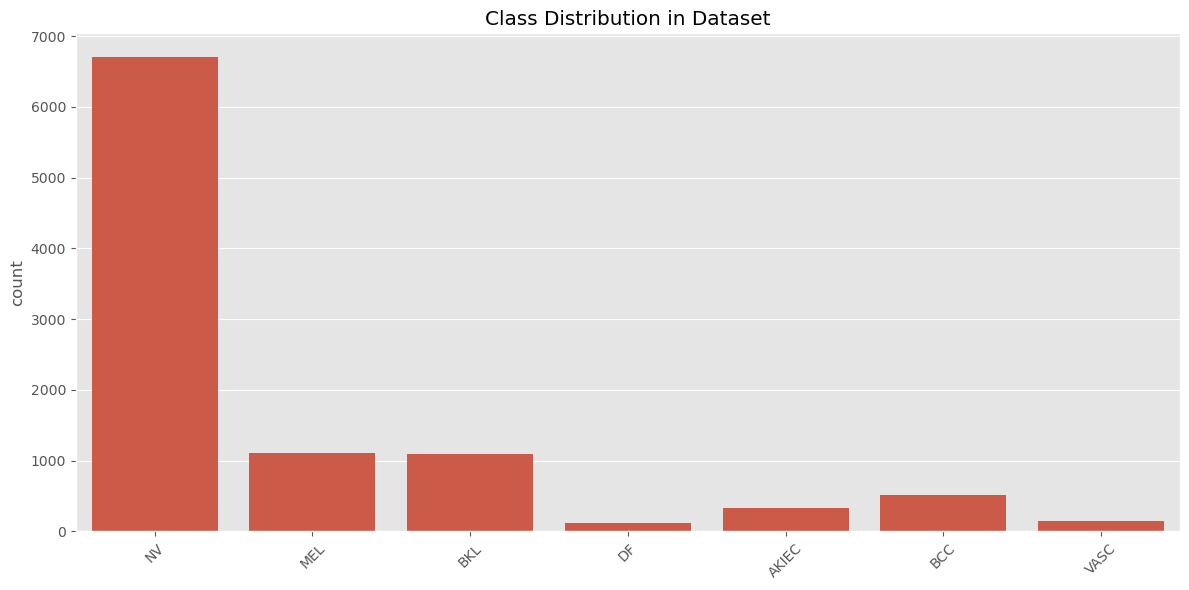

In [14]:
plt.figure(figsize=(12, 6))
sns.countplot(x=label_names)
plt.xticks(rotation=45)
plt.title('Class Distribution in Dataset')
plt.tight_layout()
plt.savefig('./plots/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Display sample images from each class

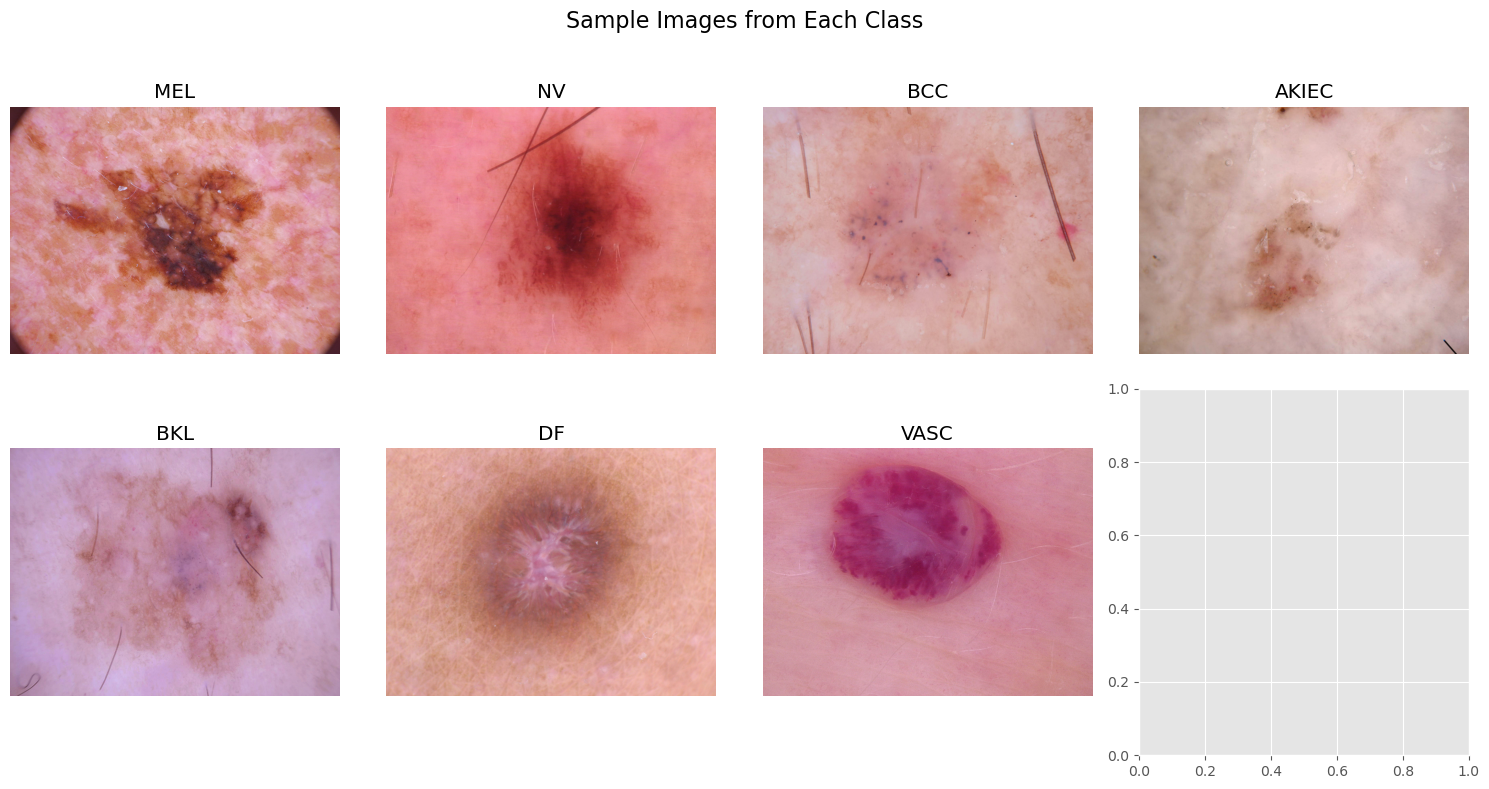

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
fig.suptitle('Sample Images from Each Class', fontsize=16)

for i, class_name in enumerate(class_names):
    class_indices = [idx for idx, name in enumerate(label_names) if name == class_name]
    if class_indices:
        img_idx = class_indices[0]
        img = Image.open(image_paths[img_idx])
        row, col = i // 4, i % 4
        axes[row, col].imshow(img)
        axes[row, col].set_title(f'{class_name}')
        axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('./plots/sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# Data preprocessing and augmentation

In [22]:
def create_data_generators(image_paths, labels, test_size=0.2, val_size=0.1, img_size=IMG_SIZE, batch_size=BATCH_SIZE):
    """Create data generators with augmentation"""
    # First split: train + validation vs test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        image_paths, labels, test_size=test_size, stratify=labels, random_state=SEED
    )
    
    # Second split: train vs validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(1-test_size), stratify=y_train_val, random_state=SEED
    )
    
    # Create dataframes
    train_df = pd.DataFrame({'filename': X_train, 'class': y_train})
    val_df = pd.DataFrame({'filename': X_val, 'class': y_val})
    test_df = pd.DataFrame({'filename': X_test, 'class': y_test})
    
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        brightness_range=[0.8, 1.2]
    )
    
    # Validation and test generators (no augmentation)
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Create generators
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='class',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='raw',
        shuffle=True,
        seed=SEED
    )
    
    val_generator = val_test_datagen.flow_from_dataframe(
        val_df,
        x_col='filename',
        y_col='class',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='raw',
        shuffle=False
    )
    
    test_generator = val_test_datagen.flow_from_dataframe(
        test_df,
        x_col='filename',
        y_col='class',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='raw',
        shuffle=False
    )
    
    return train_generator, val_generator, test_generator, class_names

In [24]:
# Create data generators

In [28]:
train_gen, val_gen, test_gen, class_names = create_data_generators(image_paths, labels)

# Get the actual class labels from the generators
def get_generator_classes(generator):
    """Extract class labels from a generator"""
    generator.reset()
    classes = []
    for i in range(len(generator)):
        _, batch_classes = generator[i]
        classes.extend(batch_classes)
    return np.array(classes[:generator.samples])

# Compute class weights to handle imbalance
train_classes = get_generator_classes(train_gen)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_classes),
    y=train_classes
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weights_dict)

Found 7010 validated image filenames.
Found 1002 validated image filenames.
Found 2003 validated image filenames.
Class weights: {0: 1.285530900421786, 1: 0.21338772031292808, 2: 2.7817460317460316, 3: 4.37305053025577, 4: 1.3022478172023035, 5: 12.517857142857142, 6: 10.014285714285714}


In [29]:
# Model building functions

In [30]:
def create_model(base_model_name='EfficientNetB0', num_classes=7, input_shape=(224, 224, 3)):
    """Create a model with transfer learning"""
    # Select base model
    if base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Unsupported base model")
    
    # Freeze base model
    base_model.trainable = False
    
    # Add custom head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

def create_ensemble_model(models_list, num_classes=7):
    """Create an ensemble model from a list of models"""
    # Create input
    input_layer = layers.Input(shape=(224, 224, 3))
    
    # Get predictions from each model
    outputs = []
    for i, model in enumerate(models_list):
        # Make sure each model is not trainable
        model.trainable = False
        # Get prediction
        pred = model(input_layer)
        outputs.append(pred)
    
    # Average predictions
    averaged = layers.Average()(outputs)
    
    # Create ensemble model
    ensemble_model = models.Model(inputs=input_layer, outputs=averaged)
    
    return ensemble_model  